# Задача
[Соревнование](https://www.kaggle.com/competitions/sberbank-russian-housing-market/overview)

Данные предоставлены Сбербанком, старейшим и крупнейшим банком России. Прогнозирование стоимости недвижимости является критически важной задачей для клиентов банка — арендаторов, застройщиков и кредиторов. Точный прогноз позволяет лучше планировать бюджеты и снижать риски. Сбербанк проводит это соревнование, чтобы привлечь сообщество специалистов по машинному обучению и данным для разработки наиболее точных моделей, способных учесть сложные взаимосвязи между характеристиками жилья и макроэкономическими факторами.

Список фичей из топ-20 с краткими описаниями
- num_room: количество комнат в квартире
- full_sq: общая площадь квартиры (кв. м)
- sport_count_5000: количество спортивных объектов в радиусе 5 км
- sport_count_3000: количество спортивных объектов в радиусе 3 км
- trc_count_5000: количество торгово-развлекательных центров (ТРЦ) в радиусе 5 км
- zd_vokzaly_avto_km: расстояние до ближайшего автовокзала (км)
- sadovoe_km: расстояние до Садового кольца (км)
- kremlin_km: расстояние до Кремля — центра Москвы (км)
- bulvar_ring_km: расстояние до Бульварного кольца (км)
- sport_count_2000: количество спортивных объектов в радиусе 2 км
- ttk_km: расстояние до Третьего транспортного кольца (км)
- office_sqm_5000: общая площадь офисных помещений в радиусе 5 км
- trc_sqm_5000: суммарная площадь ТРЦ в радиусе 5 км
- sport_count_1500: количество спортивных объектов в радиусе 1.5 км
- nuclear_reactor_km: расстояние до ближайшего ядерного объекта (км)
- sport_objects_raion: число спортивных объектов в районе
- trc_count_3000: количество ТРЦ в радиусе 3 км
- cafe_count_5000_price_1000: количество кафе в радиусе 5 км со средним чеком до 1000 руб.
- stadium_km: расстояние до ближайшего стадиона (км)
- cafe_count_5000_price_1500: количество кафе в радиусе 5 км со средним чеком до 1500 руб.

In [1]:
import os
import re
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew

from IPython.display import HTML, display
from lightautoml.automl.presets.tabular_presets import (
    TabularAutoML,
    TabularUtilizedAutoML,
)
from lightautoml.tasks import Task
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

%matplotlib inline

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

DATA_DIR = Path('../data/raw')

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/lightautoml/text/tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/lightautoml/transformers/text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


In [2]:
def visualize_distributions(
    df: pd.DataFrame,
    cols: list,
    bins: int = 30,
    log_scale: bool = False,
) -> None:
    """
    Визуализация распределений указанных колонок.

    Для каждой строки строится два графика (по два признака на строку).
    """
    df = df.copy()

    n_cols = 2
    n_features = len(cols)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

    if isinstance(axes, plt.Axes):
        axes_list = [axes]
    else:
        axes_list = np.array(axes).reshape(-1).tolist()

    for i, col in enumerate(cols):
        series = pd.to_numeric(df[col], errors="coerce").dropna()
        ax = axes_list[i]

        if log_scale:
            ax.set_xscale("log")

        ax.hist(series, bins=bins, alpha=0.8)
        ax.set_title(f"Распределение {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Плотность")
        ax.grid(alpha=0.3)

    for j in range(len(cols), len(axes_list)):
        axes_list[j].axis("off")

    plt.tight_layout()
    plt.show()

In [3]:
train_data = pd.read_csv(DATA_DIR / 'train.csv')
test_data = pd.read_csv(DATA_DIR /  'test.csv')
macro_data = pd.read_csv(DATA_DIR / 'macro.csv')

train_data = pd.merge(train_data, macro_data, how="left", on="timestamp")
test_data = pd.merge(test_data, macro_data, how="left", on="timestamp")

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (30471, 391)
Test shape: (7662, 390)


## Общий анализ данных

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)      
pd.set_option('display.max_colwidth', 50)   
pd.set_option('display.precision', 3)  


display(HTML("<h3>Train data (первые 5 строк)</h3>"))
display(train_data.head())

display(HTML("<h3>Стат. значения</h3>"))
display(test_data.describe())

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

Типы данных

In [5]:
print(train_data.dtypes)
print("\nРаспределение типов данных:")
print(train_data.dtypes.value_counts())

id                               int64
timestamp                       object
full_sq                          int64
life_sq                        float64
floor                          float64
                                ...   
bandwidth_sports               float64
population_reg_sports_share    float64
students_reg_sports_share      float64
apartment_build                float64
apartment_fund_sqm             float64
Length: 391, dtype: object

Распределение типов данных:
float64    213
int64      159
object      19
Name: count, dtype: int64


Количество пропущенных значений в каждой колонке

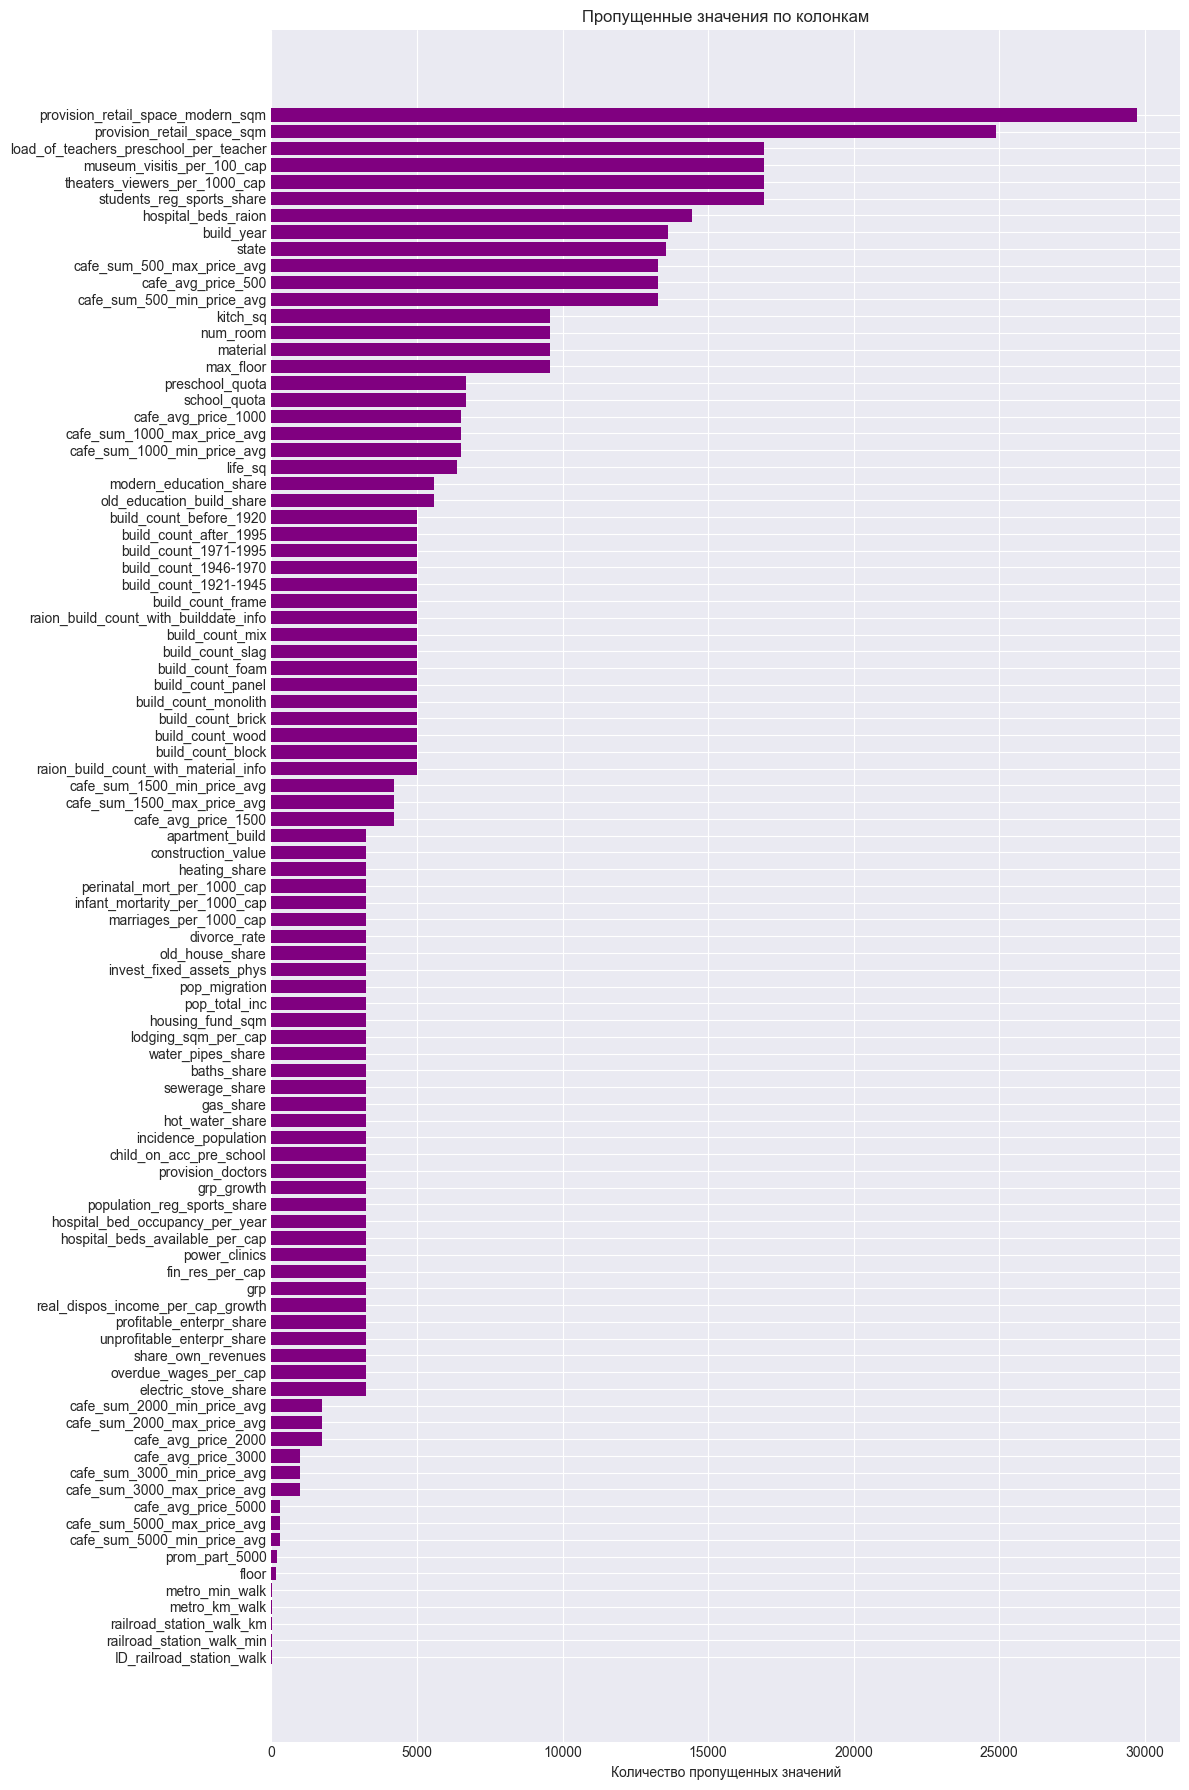

In [6]:
# Подсчёт пропущенных значений
missing_data = (
    train_data.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column_name', 0: 'missing_count'})
)
missing_data = missing_data[missing_data['missing_count'] > 0] \
    .sort_values(by='missing_count')

# Построение горизонтальной гистограммы
fig, ax = plt.subplots(figsize=(12, 18))
ax.barh(
    missing_data['column_name'],
    missing_data['missing_count'],
    color='purple'
)
ax.set_xlabel('Количество пропущенных значений')
ax.set_title('Пропущенные значения по колонкам')
plt.tight_layout()
plt.show()

В данных довольно много пропущенных значений, поэтому стоит проверить корреляцию с целевой переменной. 

Посмотрим на корреляция признаков с целевой переменной.

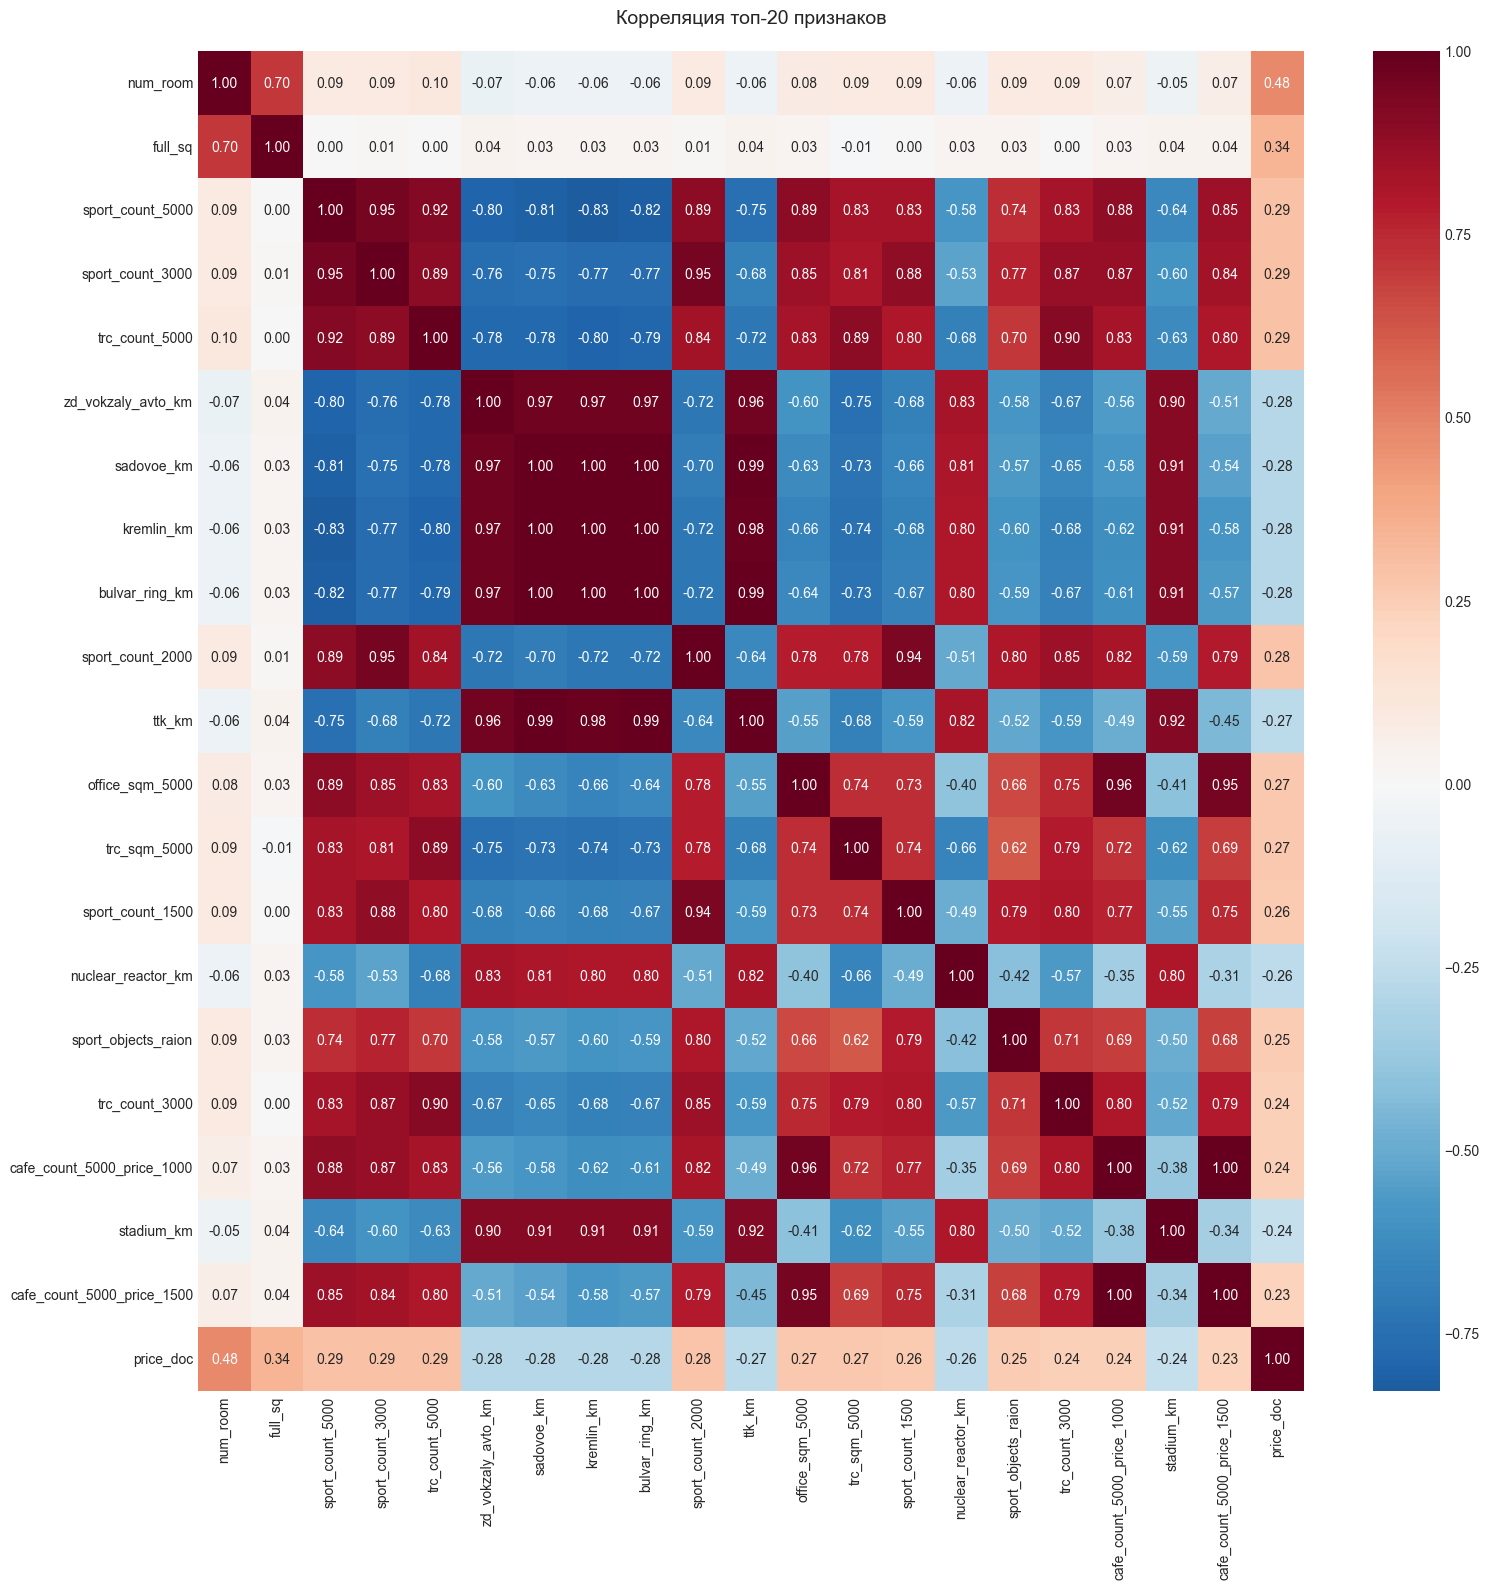

In [7]:
plt.figure(figsize=(16, 16))

top_n = 20
numeric_columns = train_data.select_dtypes(include=[np.number, np.float32]).columns
top_features = train_data[numeric_columns].corr()['price_doc'].abs().sort_values(ascending=False).index[1:top_n+1]
corr_matrix = train_data[top_features.tolist() + ['price_doc']].corr()

sns.heatmap(corr_matrix.round(2), annot=True, cmap='RdBu_r', center=0, 
            annot_kws={"size": 10}, fmt='.2f')
plt.title(f'Корреляция топ-{top_n} признаков', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Можно выделить следующие корреляции между признаками:

- num_room и full_sq: существует сильная положительная корреляция, что логично — чем больше площадь квартиры, тем больше вероятность, что в ней будет больше комнат.

- num_room и price_doc: также наблюдается положительная связь, так как квартиры с большим количеством комнат обычно стоят дороже.

- trc_count / sport_count и price_doc: между количеством торговых и спортивных объектов поблизости и ценой квартиры возникает положительная корреляция. Чем больше таких объектов рядом, тем район удобнее для жизни, выше спрос и, соответственно, цена.

- other features(like tadium_km, bulvar_ring_km): эти признаки показывают отрицательную корреляцию с ценой. Чем дальше квартира от стадиона или бульварного кольца, тем ниже престиж района и удобство проживания, что отражается на стоимости жилья.

#### Аналз целевой переменной

Рассмотрим как изменялись цены на недвижимость с течением времени.

In [10]:
# Добавим колонку с годом
train_data['year'] = pd.to_datetime(train_data['timestamp']).dt.year

# Цена в миллионах рублей
train_data['price_mln'] = train_data['price_doc'] / 1e6

# Топ-5 самых дорогих и самых дешевых сделок
top5_expensive = train_data.sort_values(by=['price_mln'], ascending=False).head(10)
top5_cheap = train_data.sort_values(by=['price_mln'], ascending=True).head(10)


# Группировка по годам
yearly_stats = train_data.groupby(['year'])['price_mln'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    skew='skew'
)

# Вычисление выбросов по IQR
Q1 = train_data['price_mln'].quantile(0.25)
Q3 = train_data['price_mln'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_lower = train_data[train_data['price_mln'] < lower_bound]
outliers_upper = train_data[train_data['price_mln'] > upper_bound]

# Визуализация
display(HTML("<h3>Статистика цен по годам</h3>"))
display(yearly_stats.reset_index())


display(HTML("<h3>Топ 10 самых дорогих сделок</h3>"))
display(top5_expensive[['timestamp', 'price_mln', 'full_sq', 'num_room', 'sub_area', 'state','floor', 'raion_popul']])


display(HTML("<h3>Топ 10 самых дешевых сделок</h3>"))
display(top5_cheap[['timestamp', 'price_mln', 'full_sq', 'num_room', 'sub_area', 'state', 'floor', 'raion_popul']])


display(HTML(f"<h3>Выбросы по IQR</h3>"
             f"<p>Процент выбросов: {outliers_lower.shape[0] + outliers_upper.shape[0]} "
             f"({((outliers_lower.shape[0] + outliers_upper.shape[0]) / train_data.shape[0]) * 100:.2f}%)</p>"
             f"<p>Границы цен: [{lower_bound:.2f}, {upper_bound:.2f}] млн рублей</p>"))

,year,count,mean,median,std,min,max,skew
0,2011,753,5.930,5.500,3.829,0.34,37.000,2.068
1,2012,4839,6.354,5.650,4.518,0.19,111.111,5.890
2,2013,7978,6.712,5.900,4.314,0.26,91.066,4.909
3,2014,13662,7.449,6.552,4.883,0.10,80.777,3.963
4,2015,3239,8.184,7.100,5.611,0.50,95.122,4.442


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
2118,2012-05-10,111.111,55,NaN,Teplyj Stan,NaN,12.0,130396
28326,2015-03-12,95.122,220,9.0,Presnenskoe,3.0,3.0,123280
7457,2013-04-19,91.066,185,NaN,Ramenki,NaN,33.0,125111
19095,2014-05-29,80.777,184,1.0,Ramenki,4.0,10.0,125111
6319,2013-03-06,78.802,206,NaN,Pokrovskoe Streshnevo,NaN,2.0,53786
3557,2012-09-10,77.000,157,NaN,Mar'ina Roshha,NaN,15.0,65972
27460,2015-01-23,71.250,151,4.0,Ajeroport,1.0,15.0,73007
11085,2013-10-08,71.200,132,4.0,Prospekt Vernadskogo,NaN,16.0,61039
5728,2013-01-21,71.034,210,NaN,Tverskoe,NaN,4.0,75377
29656,2015-05-12,70.000,211,6.0,Presnenskoe,3.0,5.0,123280


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
20244,2014-06-27,0.100,72,2.0,Gol'janovo,1.0,11.0,157010
1167,2012-02-11,0.190,38,NaN,Beskudnikovskoe,NaN,9.0,73148
1169,2012-02-13,0.200,47,NaN,Savelki,NaN,7.0,32071
9221,2013-07-16,0.260,40,NaN,Novo-Peredelkino,NaN,1.0,111023
3258,2012-08-21,0.300,31,NaN,Caricyno,NaN,5.0,125354
20388,2014-06-30,0.302,63,1.0,Rostokino,1.0,11.0,37502
2677,2012-06-27,0.331,37,NaN,Nekrasovka,NaN,4.0,19940
1596,2012-03-20,0.339,59,NaN,Nekrasovka,NaN,5.0,19940
634,2011-12-15,0.340,70,NaN,Matushkino,NaN,16.0,38075
1262,2012-02-21,0.354,66,NaN,Mitino,NaN,12.0,178473


Посмотрим на отдельные сделки недвижимости во временном промежутке

In [11]:
plt.figure(figsize=(16, 6))

dates_num = train_data['timestamp'].map(pd.Timestamp.toordinal)

plt.scatter(dates_num, train_data['price_mln'], alpha=0.2, s=20, color='blue', label='Отдельные сделки', edgecolors='none')

date_ticks = pd.date_range(train_data['timestamp'].min(), train_data['timestamp'].max(), freq='3M')
plt.xticks(
    [pd.Timestamp(d).toordinal() for d in date_ticks], 
    [d.strftime('%Y-%m') for d in date_ticks], 
    rotation=45, fontsize=10)


plt.ylabel('Цена, млн рублей', fontsize=12, fontweight='bold')
plt.xlabel('Дата совершения сделки', fontsize=12, fontweight='bold')

y_ticks = np.arange(0, train_data['price_mln'].max() + 10, 5)
plt.yticks(y_ticks, [f'{int(y)}' for y in y_ticks], fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

for q, color, style in [(0.25, 'green', '--'), (0.5, 'orange', '-'), (0.75, 'purple', '--')]:
    q_value = train_data['price_mln'].quantile(q)
    plt.axhline(y=q_value, 
                color=color, 
                linestyle=style, 
                alpha=0.5, 
                linewidth=1, 
                label=f'{int(q*100)}% квартир ≤ {q_value:.1f} млн')


plt.title('Динамика цен на недвижимость в Москве', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

AttributeError: 'str' object has no attribute 'year'

<Figure size 1600x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(16, 10))

# Гистограмма цены
plt.subplot(2, 2, 1)
sns.histplot(train_data['price_doc'], bins=100, kde=True)
plt.xlabel('Цена, руб')
plt.title('Распределение цен')

# Гистограмма лог-цены
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(train_data['price_doc']), bins=100, kde=True)
plt.xlabel('log(1 + цена)')
plt.title('Лог-распределение цен')

# Boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x=train_data['price_doc'])
plt.title('Boxplot цен (выбросы)')
plt.xlabel('Цена, руб')

# QQ-plot
plt.subplot(2, 2, 4)
stats.probplot(train_data['price_doc'], dist="norm", plot=plt)
plt.title('QQ-plot')

plt.tight_layout()
plt.show()


Избавимся от выбросов

In [ ]:
upper_limit = np.percentile(train_data['price_doc'], 99)
lower_limit = np.percentile(train_data['price_doc'], 1)

orig = train_data.shape[0]

train_data = train_data[(train_data['price_doc'] >= lower_limit) & (train_data['price_doc'] <= upper_limit)]

print(f'Удалено {orig - train_data.shape[0]} выбросов')

In [ ]:
ф

### Анализ признаков

Поскольку количество признаков слишком велико, необходимо выбрать набор признаков, которые довольно сильно коррелирует с целевым и заполнить пропущенные значения. 

Удаление малозначимых признаков:
Исключим признаки, чья корреляция с целевой переменной ниже 0.1 (для числовых признаков). Такие переменные практически не влияют на предсказание и только увеличивают шум.

In [ ]:
# # считаем корреляцию с целевой
# corr = train_data[numeric_columns].corr()['price_doc']

# # признаки с низкой корреляцией
# low_corr_features = corr[corr.abs() < 0.1].index.tolist()

# # оставшиеся числовые колонки
# numeric_columns = [col for col in numeric_columns if col not in low_corr_features]

# # вычисляем долю пропусков
# missing_data = train_data[numeric_columns].isna().sum().reset_index()
# missing_data.columns = ['column_name', 'missing_count']
# missing_data['missing_ratio'] = missing_data['missing_count'] / train_data.shape[0]

# # признаки с пропусками >=50%
# features_missing_50 = missing_data.query('missing_ratio >= 0.5')['column_name'].tolist()

# # выделяем и удаляем признаки
# features_to_drop = low_corr_features + features_missing_50
# features_to_drop = list(set(features_to_drop))

# train_data.drop(columns=features_to_drop, inplace=True)

После "жесткой" очистки в данных осталось достаточно признаков, которые следует проанализировать.  
Так как многие признаки содержат пропущенные значения, их стоит заполнять с учетом временного контекста и района.  
Кроме того, важно удалить выбросы, учитывая специфику каждого признака.

#### Категориальные признаки

Категориальные признаки будет кодировать через OrdinaEncoder.

In [ ]:
# вывести явно категориальные признаки
cat_explicit = train_data.select_dtypes(include=['object']).columns.tolist()


categorical_total = list(set(cat_explicit))
train_data[categorical_total]

,big_road1_1line,thermal_power_plant_raion,ecology,culture_objects_top_25,modern_education_share,big_market_raion,railroad_terminal_raion,sub_area,water_1line,incineration_raion,oil_chemistry_raion,radiation_raion,product_type,detention_facility_raion,nuclear_reactor_raion,railroad_1line,child_on_acc_pre_school,old_education_build_share
7672,no,no,good,no,"90,92",no,no,Kosino-Uhtomskoe,no,yes,no,yes,Investment,no,no,no,"3,013","23,14"
8056,no,no,excellent,yes,"90,92",no,no,Hamovniki,no,no,no,yes,Investment,no,no,no,"3,013","23,14"
8111,no,no,no data,no,"90,92",no,no,Poselenie Vnukovskoe,no,no,no,no,OwnerOccupier,no,no,no,"3,013","23,14"
8135,no,no,poor,no,"90,92",no,no,Lianozovo,no,no,no,yes,Investment,no,no,no,"3,013","23,14"
8144,no,no,no data,no,"90,92",no,no,Poselenie Voskresenskoe,no,no,no,no,OwnerOccupier,no,no,no,"3,013","23,14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30465,no,no,excellent,yes,"95,4918",no,yes,Tverskoe,no,no,no,yes,OwnerOccupier,yes,no,no,NaN,"8,2517"
30466,no,no,good,no,"95,4918",no,no,Otradnoe,no,yes,no,yes,Investment,no,no,no,NaN,"8,2517"
30468,no,no,no data,no,"95,4918",no,no,Poselenie Vnukovskoe,no,no,no,no,OwnerOccupier,no,no,no,NaN,"8,2517"
30469,no,no,satisfactory,no,"95,4918",no,no,Obruchevskoe,no,no,no,yes,Investment,no,no,no,NaN,"8,2517"


#### timestamp
Изменим тип данных на datetime для более удобной работы и посчитаем статистику.

In [ ]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

timestamp_stats = {
    'min_date': train_data['timestamp'].min(),
    'max_date': train_data['timestamp'].max(),
    'n_unique': train_data['timestamp'].nunique(),
    'range_days': (train_data['timestamp'].max() - train_data['timestamp'].min()).days
}

pd.DataFrame(timestamp_stats, index=[0])

,min_date,max_date,n_unique,range_days
0,2011-08-20,2015-06-30,1161,1410


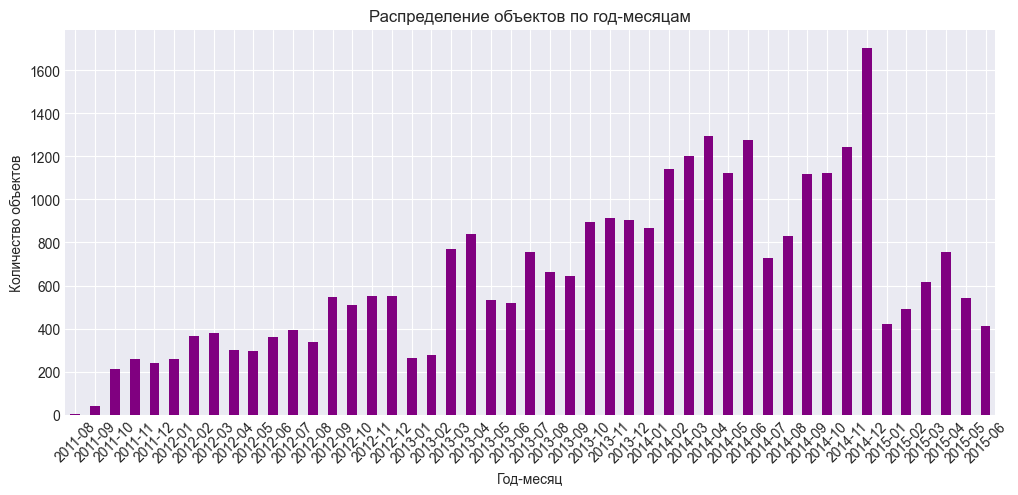

In [ ]:
# извлекаем год и месяц из timestamp
train_data['year_month'] = train_data['timestamp'].dt.to_period('M')


# Распределение объектов по год-месяц
plt.figure(figsize=(12, 5))
train_data['year_month'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Распределение объектов по год-месяцам')
plt.xlabel('Год-месяц')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.show()

# удаляем лишнюю фичу
train_data.drop(columns=['year_month'], inplace=True)

Краткий анализ:
- Наибольшая активность наблюдалась в конце 2014 года (декабрь 2014 – 1705 записей).

- В начале периода (2011) количество записей было минимальным (август 2011 – 3 записи).

- Есть рост с 2012 по 2014 годы, затем небольшое падение в 2015.

Данные имеют сезонные колебания, например, зимой и осенью наблюдается больше записей. Видимо, в это время банки и застройщики активнее публикуют данные о недвижимости.

#### price_doc (price_doc в млн. руб)
Рассмотрим как изменялись цены на недвижимость с течением времени.

In [ ]:
# Добавим колонку с годом
train_data['year'] = pd.to_datetime(train_data['timestamp']).dt.year

# Цена в миллионах рублей
train_data['price_mln'] = train_data['price_doc'] / 1e6

# Топ-5 самых дорогих и самых дешевых сделок
top5_expensive = train_data.sort_values(by=['price_mln'], ascending=False).head(10)
top5_cheap = train_data.sort_values(by=['price_mln'], ascending=True).head(10)


# Группировка по годам
yearly_stats = train_data.groupby(['year'])['price_mln'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    skew='skew'
)

# Вычисление выбросов по IQR
Q1 = train_data['price_mln'].quantile(0.25)
Q3 = train_data['price_mln'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_lower = train_data[train_data['price_mln'] < lower_bound]
outliers_upper = train_data[train_data['price_mln'] > upper_bound]

# Визуализация
display(HTML("<h3>Статистика цен по годам</h3>"))
display(yearly_stats.reset_index())


display(HTML("<h3>Топ 10 самых дорогих сделок</h3>"))
display(top5_expensive[['timestamp', 'price_mln', 'full_sq', 'num_room', 'sub_area', 'state','floor', 'raion_popul']])


display(HTML("<h3>Топ 10 самых дешевых сделок</h3>"))
display(top5_cheap[['timestamp', 'price_mln', 'full_sq', 'num_room', 'sub_area', 'state', 'floor', 'raion_popul']])


display(HTML(f"<h3>Выбросы по IQR</h3>"
             f"<p>Процент выбросов: {outliers_lower.shape[0] + outliers_upper.shape[0]} "
             f"({((outliers_lower.shape[0] + outliers_upper.shape[0]) / train_data.shape[0]) * 100:.2f}%)</p>"
             f"<p>Границы цен: [{lower_bound:.2f}, {upper_bound:.2f}] млн рублей</p>"))

,year,count,mean,median,std,min,max,skew
0,2011,753,5.930,5.500,3.829,0.34,37.000,2.068
1,2012,4839,6.354,5.650,4.518,0.19,111.111,5.890
2,2013,7978,6.712,5.900,4.314,0.26,91.066,4.909
3,2014,13662,7.449,6.552,4.883,0.10,80.777,3.963
4,2015,3239,8.184,7.100,5.611,0.50,95.122,4.442


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
2118,2012-05-10,111.111,55,NaN,Teplyj Stan,NaN,12.0,130396
28326,2015-03-12,95.122,220,9.0,Presnenskoe,3.0,3.0,123280
7457,2013-04-19,91.066,185,NaN,Ramenki,NaN,33.0,125111
19095,2014-05-29,80.777,184,1.0,Ramenki,4.0,10.0,125111
6319,2013-03-06,78.802,206,NaN,Pokrovskoe Streshnevo,NaN,2.0,53786
3557,2012-09-10,77.000,157,NaN,Mar'ina Roshha,NaN,15.0,65972
27460,2015-01-23,71.250,151,4.0,Ajeroport,1.0,15.0,73007
11085,2013-10-08,71.200,132,4.0,Prospekt Vernadskogo,NaN,16.0,61039
5728,2013-01-21,71.034,210,NaN,Tverskoe,NaN,4.0,75377
29656,2015-05-12,70.000,211,6.0,Presnenskoe,3.0,5.0,123280


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
20244,2014-06-27,0.100,72,2.0,Gol'janovo,1.0,11.0,157010
1167,2012-02-11,0.190,38,NaN,Beskudnikovskoe,NaN,9.0,73148
1169,2012-02-13,0.200,47,NaN,Savelki,NaN,7.0,32071
9221,2013-07-16,0.260,40,NaN,Novo-Peredelkino,NaN,1.0,111023
3258,2012-08-21,0.300,31,NaN,Caricyno,NaN,5.0,125354
20388,2014-06-30,0.302,63,1.0,Rostokino,1.0,11.0,37502
2677,2012-06-27,0.331,37,NaN,Nekrasovka,NaN,4.0,19940
1596,2012-03-20,0.339,59,NaN,Nekrasovka,NaN,5.0,19940
634,2011-12-15,0.340,70,NaN,Matushkino,NaN,16.0,38075
1262,2012-02-21,0.354,66,NaN,Mitino,NaN,12.0,178473


Посмотрим на отдельные сделки недвижимости во временном промежутке

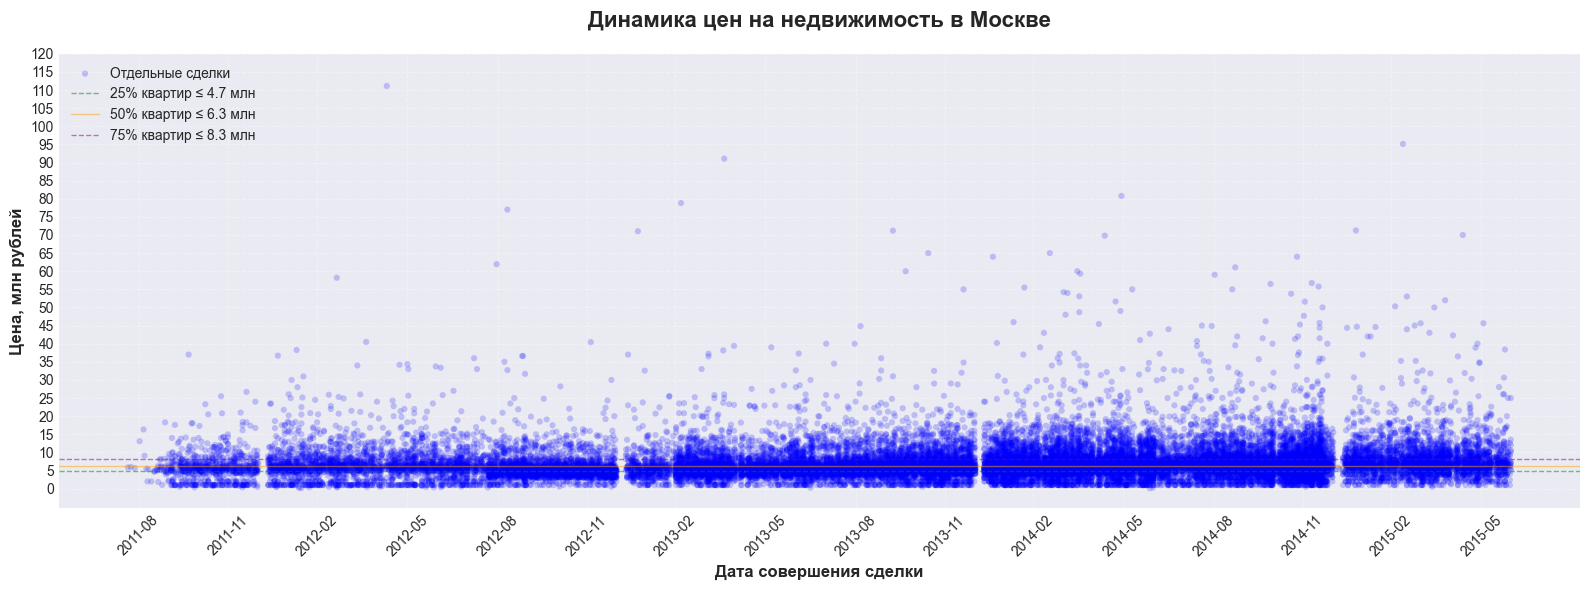

In [ ]:
plt.figure(figsize=(16, 6))

dates_num = train_data['timestamp'].map(pd.Timestamp.toordinal)

plt.scatter(dates_num, train_data['price_mln'], alpha=0.2, s=20, color='blue', label='Отдельные сделки', edgecolors='none')

date_ticks = pd.date_range(train_data['timestamp'].min(), train_data['timestamp'].max(), freq='3M')
plt.xticks(
    [pd.Timestamp(d).toordinal() for d in date_ticks], 
    [d.strftime('%Y-%m') for d in date_ticks], 
    rotation=45, fontsize=10)


plt.ylabel('Цена, млн рублей', fontsize=12, fontweight='bold')
plt.xlabel('Дата совершения сделки', fontsize=12, fontweight='bold')

y_ticks = np.arange(0, train_data['price_mln'].max() + 10, 5)
plt.yticks(y_ticks, [f'{int(y)}' for y in y_ticks], fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

for q, color, style in [(0.25, 'green', '--'), (0.5, 'orange', '-'), (0.75, 'purple', '--')]:
    q_value = train_data['price_mln'].quantile(q)
    plt.axhline(y=q_value, 
                color=color, 
                linestyle=style, 
                alpha=0.5, 
                linewidth=1, 
                label=f'{int(q*100)}% квартир ≤ {q_value:.1f} млн')


plt.title('Динамика цен на недвижимость в Москве', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

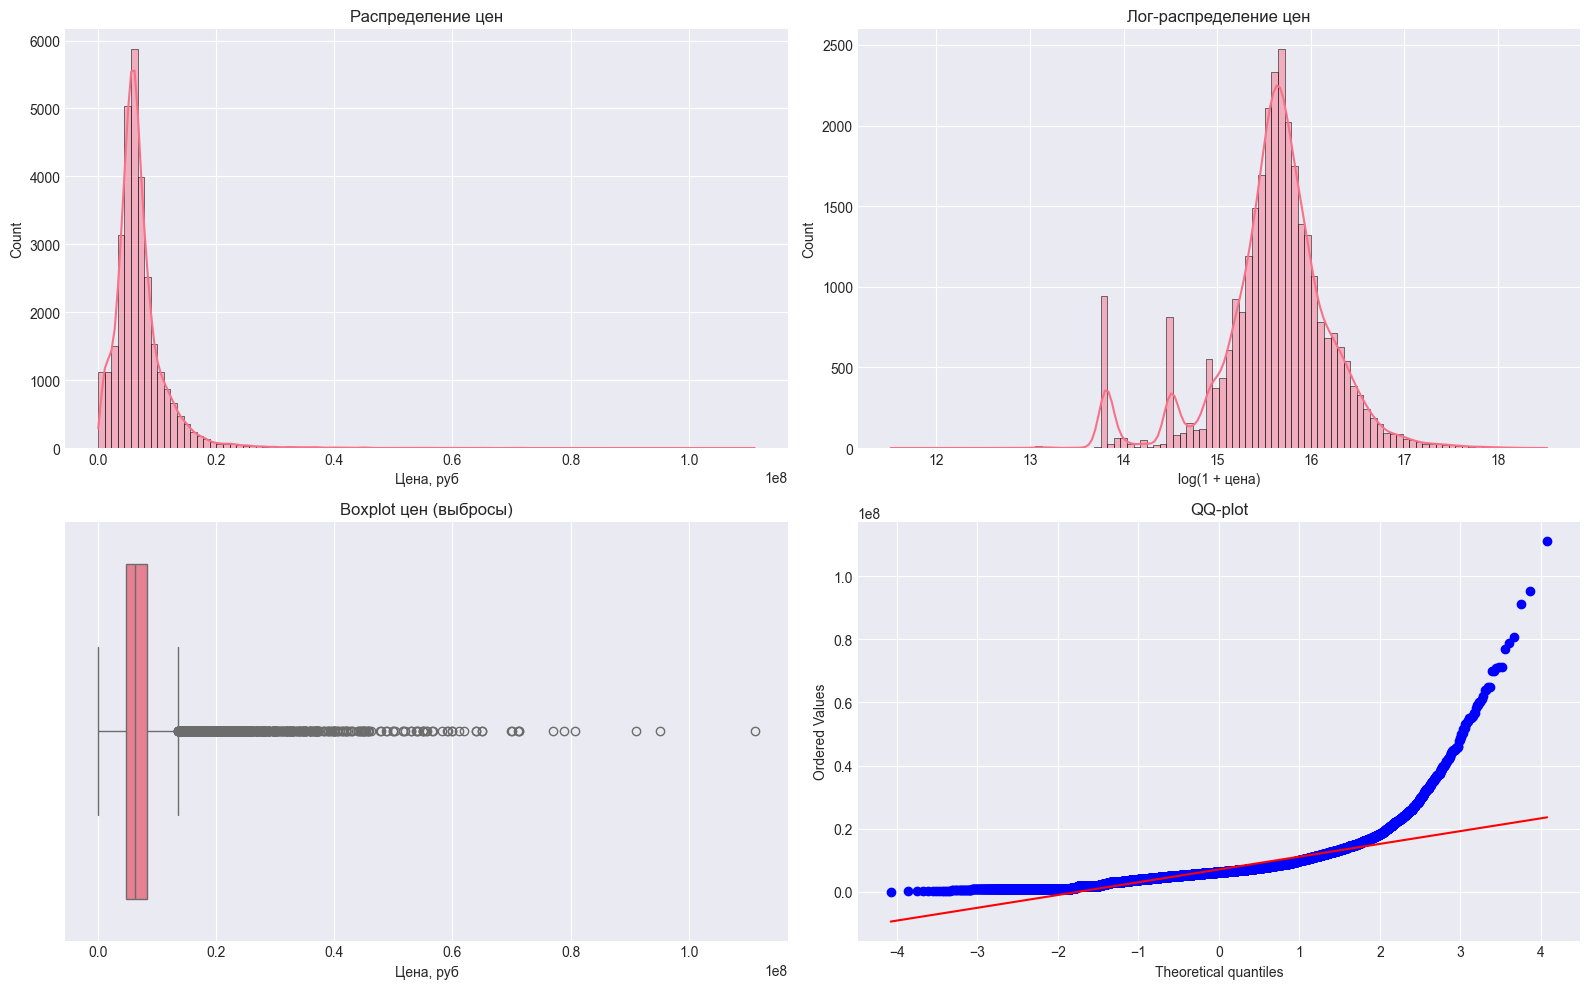

In [ ]:
plt.figure(figsize=(16, 10))

# Гистограмма цены
plt.subplot(2, 2, 1)
sns.histplot(train_data['price_doc'], bins=100, kde=True)
plt.xlabel('Цена, руб')
plt.title('Распределение цен')

# Гистограмма лог-цены
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(train_data['price_doc']), bins=100, kde=True)
plt.xlabel('log(1 + цена)')
plt.title('Лог-распределение цен')

# Boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x=train_data['price_doc'])
plt.title('Boxplot цен (выбросы)')
plt.xlabel('Цена, руб')

# QQ-plot
plt.subplot(2, 2, 4)
stats.probplot(train_data['price_doc'], dist="norm", plot=plt)
plt.title('QQ-plot')

plt.tight_layout()
plt.show()


Избавимся от выбросов

In [ ]:
upper_limit = np.percentile(train_data['price_doc'], 99)
lower_limit = np.percentile(train_data['price_doc'], 1)

orig = train_data.shape[0]

train_data = train_data[(train_data['price_doc'] >= lower_limit) & (train_data['price_doc'] <= upper_limit)]

print(f'Удалено {orig - train_data.shape[0]} выбросов')

Удалено 538 выбросов


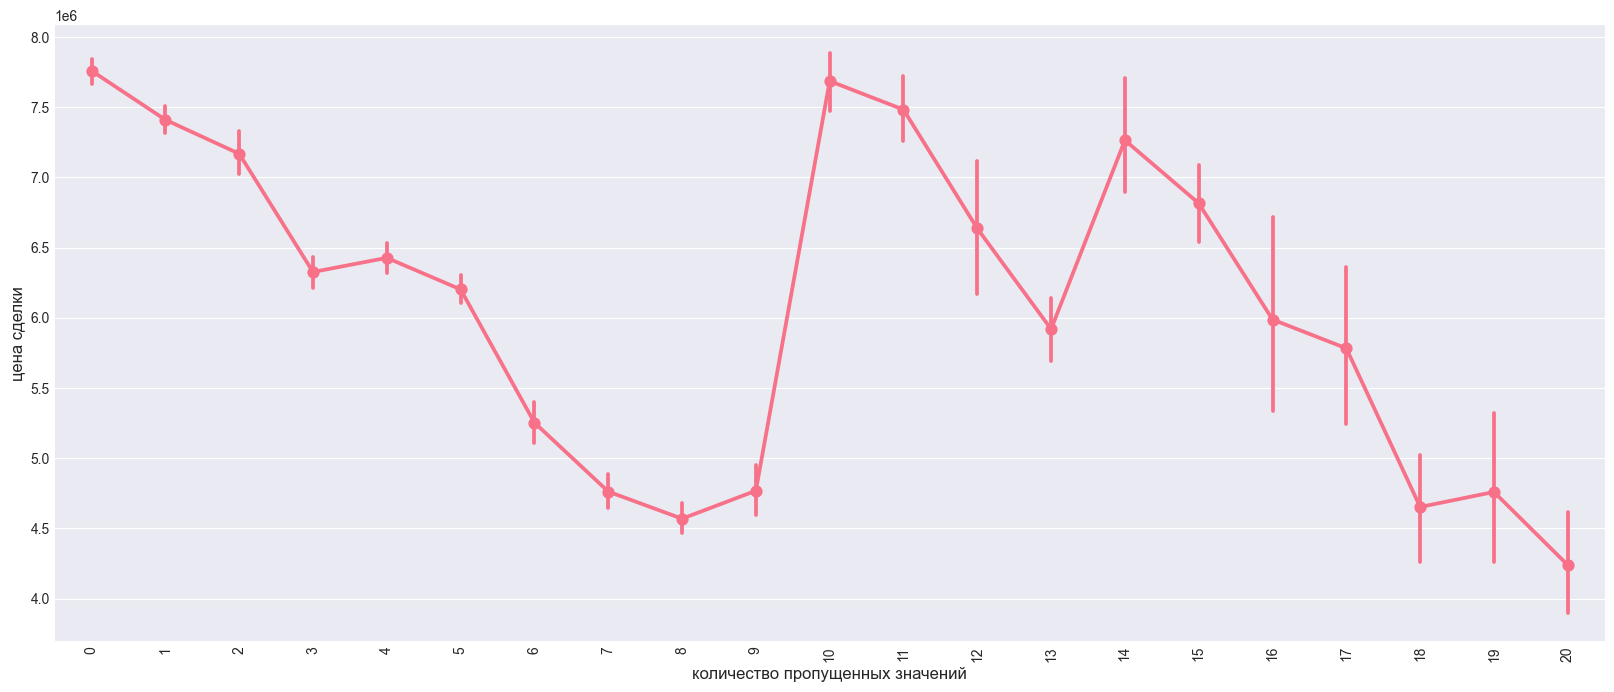

In [ ]:
# посмотрим зависимость price_doc от кол. пропущенных значений
train_data['null_count'] = train_data.isnull().sum(axis=1)

plt.figure(figsize=(20, 8))
sns.pointplot(x='null_count', y='price_doc', data=train_data)
plt.ylabel('цена сделки', fontsize=12)
plt.xlabel('количество пропущенных значений', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

На графике наблюдается **слабая отрицательная корреляция** – чем больше пропущенных значений, тем меньше цена квартиры.  
_Гипотеза_: дешевые квартиры хуже описаны в БД в отличие от дорогих.

##### Выводы по анализу price_doc

- Рынок в 2011–2015 демонстрирует устойчивый рост цен, при этом растёт и разброс цен: появляются как более дорогие, так и более дешёвые сделки — рынок становится более неоднородным.

- Верхний хвост содержит смесь реальных элитных сделок и явных аномалий, нижний хвост тоже включает большое число некорректных записей.

- ```Skewness > 2``` — показывает сильную положительную асимметрию: распределение сильно скошено вправо. QQ-plot и значительная разница между mean и median подтверждают, что данные дальше от нормального распределения, особенно в верхнем хвосте.

Поскольку наличие выбросов искажает средние, дисперсию и метрики ошибки, из-за чего модель может "подгоняться" под редкие экстремумы и хуже предсказывать массовый рынок, то стоило от подобного вида выбросов избавиться.

#### num_room

Для признака num_room проведём обработку выбросов по следующим правилам:

- num_room == 0 считается выбросом, так как квартиры без комнат не имеют смысла.

- num_room <= 20 не считается выбросом: в 2016 году была зафиксирована квартира в Москве с 20 комнатами ([источник](https://www.mirkvartir.ru/journal/analytics/2016/08/22/samaa-mnogokomnatnaa-kvartira-v-rossii-sostoit-iz-20-pomesenii/?utm_source=chatgpt.com&utm_referrer=https%3A%2F%2Fchatgpt.com%2F)), поэтому такие значения крайне редки, но реально существуют и не являются аномалией. 

In [ ]:
# отбираем релевантные признаки
train_data = train_data.query('num_room <= 20 and num_room > 0')
test_data = test_data.query('num_room <= 20 and num_room > 0')

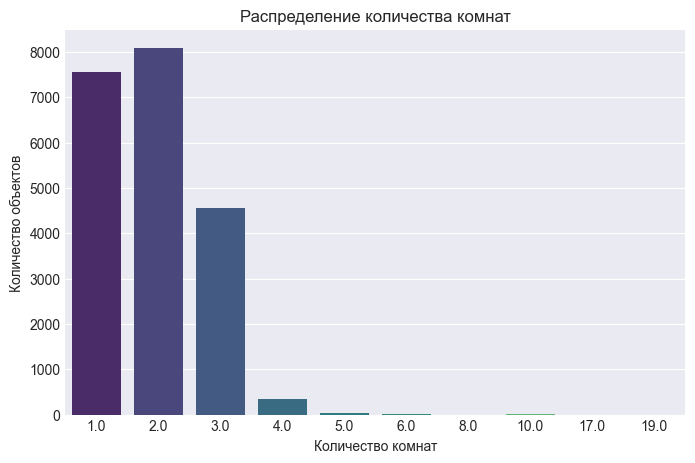

In [ ]:
# Распределение количества комнат
plt.figure(figsize=(8,5))
sns.countplot(x='num_room', data=train_data, palette='viridis')
plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов')
plt.show()

Больше всего Распространены 1-3 комантные квартиры.

#### life_sq

Для избавления пропущенных значений будем использовть данные по группа: sub_area, year, num_room и product_type.

Признаки:
- sub_area — район, где находится квартира. Разные районы имеют разную плотность застройки и тип жилья.

- year — год, извлечённый из временной метки timestamp. Цены и типы жилья меняются со временем, поэтому важно учитывать временной контекст.

- product_type — тип недвижимости. Жилые площади различаются по типу продукта.
- num_room - кол. комнат в квартире. 

```Гипотеза```: квартиры с похожим расположением, годом, кол. комнат и типом продукта обычно имеют схожее соотношение life_sq / full_sq.

In [ ]:
def fill_life_sq(df: pd.DataFrame) -> pd.DataFrame:
    """
    Заполняет пропущенные значения life_sq на основе отношения
    life_sq / full_sq внутри группы (sub_area, year, product_type),
    а затем медианы life_sq по той же группе.
    """
    df = df.copy()

    # получаем год из временной метки
    df["year"] = pd.to_datetime(df['timestamp'], errors="coerce").dt.year

    # вычисляем отношение life_sq / full_sq
    df["ratio"] = np.where(
        df["life_sq"].notna() & df["full_sq"].notna(),
        df["life_sq"] / df["full_sq"],
        np.nan
    )

    # Медианное отношение в группе (sub_area, year, product_type_
    df["ratio_group"] = df.groupby(['sub_area', "year", 'product_type', 'num_room'])["ratio"].transform("median")

    # Заполняем life_sq через full_sq * медианное отношение
    mask_fill = df["life_sq"].isna() & df["full_sq"].notna() & df["ratio_group"].notna()
    df.loc[mask_fill, "life_sq"] = (
        df.loc[mask_fill, "full_sq"] * df.loc[mask_fill, "ratio_group"]
    )

    # Убираем вспомогательные колонки
    drop_cols = ["year", "ratio", "ratio_group"]
    df.drop(columns=drop_cols, inplace=True)

    return df


# Избавляемся от выбросов
train_data = fill_life_sq(train_data)
test_data = fill_life_sq(test_data)

train_data = train_data[train_data["life_sq"] <= train_data["full_sq"]]
test_data = test_data[test_data["life_sq"] <= test_data["full_sq"]]

#### Цены и количество кафе поблизости

Будем заполнять пропущенные значения в признаках кафе (цены и суммы по разным радиусам):
- Для объектов, где рядом нет кафе, заполняем суммы и средние цены нулями.
- Для остальных заполняем пропуски медианой, то есть внутри группы района (sub_area) и месяца (year_month)

In [ ]:
# выделяем признаки с которыми будем работать
CAFE_PRICE_COLS = [
        'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
        'cafe_avg_price_1500', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000'
    ]

# определяем сколько Nan значений содержится в данных о кафе
train_data[CAFE_PRICE_COLS].isna().sum()

cafe_sum_1500_min_price_avg    2583
cafe_sum_1500_max_price_avg    2583
cafe_avg_price_1500            2583
cafe_sum_2000_max_price_avg    1101
cafe_avg_price_2000            1101
dtype: int64

In [ ]:
def fill_cafe_prices(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Заполняет пропущенные значения в колонках с ценами кафе.
    - Сначала заполняем 0 там, где нет объекта кафе.
    - Затем заполняем медианой по (sub_area, year_month), затем sub_area, затем year_month.
    - Восстанавливаем сумму по avg для колонки с radius 5000, если она пропущена.
    """
    df = df.copy()
    
    # получаем месяц опред. года из временной метки
    df['year_month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')

    # Заполняем 0 там, где нет кафе
    # Заменяем пропуски NaN на 0, так как если кафе нет, сумма цен логично 0
    mask_no_cafes = (df[cols].sum(axis=1) == 0)
    df.loc[mask_no_cafes, cols] = df.loc[mask_no_cafes, cols].fillna(0)

    # Заполняем медианой по группам
    for col in cols:
        df[col] = df.groupby(['sub_area', 'year_month'])[col].transform(
            lambda x: x.fillna(x.median())
        )

    # избавляемся от промежуточных данных
    df.drop(columns=['year_month'], inplace=True)
    return df
    

train_data = fill_cafe_prices(train_data, CAFE_PRICE_COLS)
test_data = fill_cafe_prices(test_data, CAFE_PRICE_COLS)

In [ ]:
# определяем сколько Nan значений содержится в train / test
print(train_data[CAFE_PRICE_COLS].isna().sum())
print(test_data[CAFE_PRICE_COLS].isna().sum())

cafe_sum_1500_min_price_avg    53
cafe_sum_1500_max_price_avg    53
cafe_avg_price_1500            53
cafe_sum_2000_max_price_avg     0
cafe_avg_price_2000             0
dtype: int64
cafe_sum_1500_min_price_avg    7
cafe_sum_1500_max_price_avg    7
cafe_avg_price_1500            7
cafe_sum_2000_max_price_avg    0
cafe_avg_price_2000            0
dtype: int64


Поскольку после обработки сохранилось малое количество Nan значений как на train, так и на test, то можем их удалить.

In [ ]:
# осталась малая часть данных
train_data.dropna(subset=CAFE_PRICE_COLS, inplace=True)
test_data.dropna(subset=CAFE_PRICE_COLS, inplace=True)

#### Здравоохранения
Features:
- provision_doctors — обеспеченность врачами

- hospital_bed_occupancy_per_year — загрузка коек в год

- hospital_beds_available_per_cap — количество коек на душу населения

- hospital_beds_raion — количество больничных коек в районе

Удалим все признаки, поскольку они не коррелируют с целевым признаком.

In [ ]:
HOSPITAL_COLS = ['hospital_bed_occupancy_per_year', 'provision_doctors', 
            'hospital_beds_available_per_cap', 'hospital_beds_raion', 'price_doc']

print('Корреляция признаков hospital')
display(train_data[HOSPITAL_COLS].corr())

train_data.drop(columns=HOSPITAL_COLS[:-1], inplace=True)
print('признаки удалены')

Корреляция признаков hospital


,hospital_bed_occupancy_per_year,provision_doctors,hospital_beds_available_per_cap,hospital_beds_raion,price_doc
hospital_bed_occupancy_per_year,1.000,1.000,1.000,0.007,-0.038
provision_doctors,1.000,1.000,1.000,0.007,-0.038
hospital_beds_available_per_cap,1.000,1.000,1.000,0.007,-0.038
hospital_beds_raion,0.007,0.007,0.007,1.000,0.093
price_doc,-0.038,-0.038,-0.038,0.093,1.000


признаки удалены


#### Недвижимость и застройка
- build_count_monolith — количество монолитных зданий

- build_count_brick — количество кирпичных зданий

- state — состояние здания (вероятно, новый/старый/снос и т.д.)

In [ ]:
# train_data[['state','build_count_monolith','build_count_brick']].value_counts()

#### Экономика и предприятия
Features:
- grp — валовой региональный продукт

- fin_res_per_cap — финансовые ресурсы на душу населения

- profitable_enterpr_share — доля прибыльных предприятий

- unprofitable_enterpr_share — доля убыточных предприятий

- construction_value — стоимость строительства

In [ ]:
ECONOMIC = ['grp', 'fin_res_per_cap', 'profitable_enterpr_share', 'unprofitable_enterpr_share', 'construction_value', 'price_doc']

print('Корреляция признаков economic')
display(train_data[ECONOMIC].corr())

train_data.drop(columns=ECONOMIC[:-1], inplace=True)
print('признаки удалены')

Корреляция признаков economic


,grp,fin_res_per_cap,profitable_enterpr_share,unprofitable_enterpr_share,construction_value,price_doc
grp,1.000,-1.000,-1.000,1.000,1.000,0.038
fin_res_per_cap,-1.000,1.000,1.000,-1.000,-1.000,-0.038
profitable_enterpr_share,-1.000,1.000,1.000,-1.000,-1.000,-0.038
unprofitable_enterpr_share,1.000,-1.000,-1.000,1.000,1.000,0.038
construction_value,1.000,-1.000,-1.000,1.000,1.000,0.038
price_doc,0.038,-0.038,-0.038,0.038,0.038,1.000


признаки удалены


In [ ]:
missing_data = (
    train_data.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column_name', 0: 'missing_count'})
)
missing_data = missing_data[missing_data['missing_count'] > 0] \
    .sort_values(by='missing_count')

missing_data

,column_name,missing_count
55,metro_min_walk,24
56,metro_km_walk,24
60,railroad_station_walk_km,24
61,railroad_station_walk_min,24
211,incidence_population,3143
212,child_on_acc_pre_school,3143
51,build_count_brick,3241
52,build_count_monolith,3241
6,state,3850


In [ ]:
a = list(missing_data['column_name'].unique())
a.append('price_doc')

train_data[a].dtypes

metro_min_walk               float64
metro_km_walk                float64
railroad_station_walk_km     float64
railroad_station_walk_min    float64
incidence_population         float64
child_on_acc_pre_school       object
build_count_brick            float64
build_count_monolith         float64
state                        float64
price_doc                      int64
dtype: object

In [ ]:
a = []
a.extend(missing_data.column_name.to_list())
a.append('price_doc')

In [ ]:
train_data[a]

,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,incidence_population,child_on_acc_pre_school,build_count_brick,build_count_monolith,state,price_doc
7672,7.578,0.632,2.890,34.681,684.2,"3,013",179.0,14.0,NaN,10100000
8056,6.990,0.583,2.447,29.370,684.2,"3,013",550.0,48.0,3.0,2750000
8111,27.430,2.286,4.299,51.591,684.2,"3,013",NaN,NaN,NaN,7574496
8135,18.420,1.535,3.565,42.776,684.2,"3,013",71.0,13.0,3.0,9000000
8144,25.863,2.155,5.685,68.215,684.2,"3,013",NaN,NaN,NaN,4457400
...,...,...,...,...,...,...,...,...,...,...
30465,13.459,1.122,3.379,40.545,NaN,NaN,529.0,25.0,1.0,6750554
30466,8.158,0.680,3.147,37.766,NaN,NaN,20.0,5.0,3.0,7400000
30468,20.667,1.722,3.736,44.828,NaN,NaN,NaN,NaN,1.0,6970959
30469,24.568,2.047,6.896,82.750,NaN,NaN,4.0,9.0,2.0,13500000


In [ ]:
# вывести явно категориальные признаки
cat_explicit = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

# вывести числовые, но с малым числом уникальных значений, вероятные категории
cat_numeric_like = [
    col for col in train_data.columns
    if train_data[col].dtype != 'object' 
    and train_data[col].nunique() <= 20
]

categorical_total = list(set(cat_explicit + cat_numeric_like))
train_data[categorical_total]


,big_road1_1line,bandwidth_sports,big_market_raion,turnover_catering_per_cap,mosque_count_5000,invest_fixed_assets,labor_force,incidence_population,leisure_count_500,thermal_power_plant_raion,culture_objects_top_25,cafe_count_1000_price_high,market_count_3000,salary,retail_trade_turnover,university_top_20_raion,radiation_raion,child_on_acc_pre_school,old_education_build_share,product_type,gdp_deflator,nuclear_reactor_raion,employment,healthcare_centers_raion,cafe_count_1500_price_high,mosque_count_2000,ecology,railroad_terminal_raion,num_room,preschool_education_centers_raion,water_1line,school_education_centers_raion,gdp_annual,load_on_doctors,incineration_raion,oil_chemistry_raion,detention_facility_raion,market_count_2000,provision_nurse,average_life_exp,modern_education_share,invest_fixed_capital_per_cap,sub_area,mosque_count_1500,school_education_centers_top_20_raion,retail_trade_turnover_per_cap,cafe_count_2000_price_high,railroad_1line,load_of_teachers_school_per_teacher,gdp_annual_growth,shopping_centers_raion,state
7672,no,329348.0,no,9350.0,0,1413.094,6879.314,684.2,0,no,no,0,1,55485.2,4016.987,0,yes,"3,013","23,14",Investment,108.299,no,0.718,1,0,0,good,no,2.0,4,no,5,66926.9,8846.956,yes,no,no,1,97.9,76.37,"90,92",117328.65,Kosino-Uhtomskoe,0,0,333.529,0,no,1437.740,0.035,0,NaN
8056,no,329348.0,no,9350.0,1,1413.094,6879.314,684.2,9,no,yes,0,4,55485.2,4016.987,1,yes,"3,013","23,14",Investment,108.299,no,0.718,5,0,0,excellent,no,1.0,5,no,8,66926.9,8846.956,no,no,no,3,97.9,76.37,"90,92",117328.65,Hamovniki,0,1,333.529,4,no,1437.740,0.035,5,3.0
8111,no,329348.0,no,9350.0,0,1413.094,6879.314,684.2,0,no,no,0,0,55485.2,4016.987,0,no,"3,013","23,14",OwnerOccupier,108.299,no,0.718,0,0,0,no data,no,3.0,0,no,0,66926.9,8846.956,no,no,no,0,97.9,76.37,"90,92",117328.65,Poselenie Vnukovskoe,0,0,333.529,0,no,1437.740,0.035,1,NaN
8135,no,329348.0,no,9350.0,1,1413.094,6879.314,684.2,0,no,no,0,2,55485.2,4016.987,0,yes,"3,013","23,14",Investment,108.299,no,0.718,3,0,0,poor,no,2.0,5,no,5,66926.9,8846.956,no,no,no,2,97.9,76.37,"90,92",117328.65,Lianozovo,0,0,333.529,0,no,1437.740,0.035,3,3.0
8144,no,329348.0,no,9350.0,1,1413.094,6879.314,684.2,0,no,no,0,0,55485.2,4016.987,0,no,"3,013","23,14",OwnerOccupier,108.299,no,0.718,0,0,0,no data,no,1.0,0,no,0,66926.9,8846.956,no,no,no,0,97.9,76.37,"90,92",117328.65,Poselenie Voskresenskoe,0,0,333.529,0,no,1437.740,0.035,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30465,no,463938.0,no,10805.0,2,1611.512,7067.470,NaN,0,no,yes,1,6,64310.0,4310.107,2,yes,NaN,"8,2517",OwnerOccupier,123.661,no,0.734,3,5,1,excellent,yes,2.0,4,no,4,77945.1,6899.930,no,no,yes,2,90.8,76.77,"95,4918",131403.00,Tverskoe,0,1,351.448,10,no,1573.651,0.007,23,1.0
30466,no,463938.0,no,10805.0,1,1611.512,7067.470,NaN,0,no,no,0,3,64310.0,4310.107,0,yes,NaN,"8,2517",Investment,123.661,no,0.734,1,0,1,good,no,2.0,4,no,4,77945.1,6899.930,yes,no,no,3,90.8,76.77,"95,4918",131403.00,Otradnoe,0,0,351.448,0,no,1573.651,0.007,9,3.0
30468,no,463938.0,no,10805.0,0,1611.512,7067.470,NaN,0,no,no,0,0,64310.0,4310.107,0,no,NaN,"8,2517",OwnerOccupier,123.661,no,0.734,0,0,0,no data,no,1.0,0,no,0,77945.1,6899.930,no,no,no,0,90.8,76.77,"95,4918",131403.00,Poselenie Vnukovskoe,0,0,351.448,0,no,1573.651,0.007,1,1.0
30469,no,463938.0,no,10805.0,1,1611.512,7067.470,NaN,0,no,no,0,4,64310.0,4310.107,1,yes,NaN,"8,2517",Investment,123.661,no,0.734,2,0,0,satisfactory,no,2.0,6,no,8,77945.1,6899.930,no,no,no,2,90.8,76.77,"95,4918",131403.00,Obruchevskoe,0,0,351.448,0,no,1573.651,0.007,4,2.0
